# $K$-Means Clustering and Principal Component Analysis

## $K$-Means Clustering

In [1]:
%matplotlib inline
# To get nice quality plots
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
def find_closest_centroids(X, centroids):
    """ For each sample in X this function caclculates the index of 
    the nearest centroid based on euclidian distance"""
    # Number of centroids:
    K = centroids.shape[0]
    # Number of samples
    m = X.shape[0]
    
    # Array to hold nearest centroid indices of samples:
    idx = np.zeros((m, 1))
    
    # Array to temporarly hold distance values of a fixed sample to the centroids
    c_distances = np.zeros((K, 1))
   
    for i in range(m):
        for k in range(K):
            c_distances[k] = np.sum((X[i, :] - centroids[k, :]) ** 2)
        # idx[i] is the index of the centroid nearest to sample x_i 
        idx[i] = np.argmin(c_distances)
        
    return idx

In [3]:
# Test the function on some sample data
data1 = loadmat('data/ex7data2.mat')
X1 = data1['X']

init_centroids = np.array([[3, 3], [6, 2], [8, 5]])
init_idx = find_closest_centroids(X1, init_centroids)
# Notice python array indexing starts at 0 (compared to 1 in Matlab)
print(init_idx[:3])

[[0.]
 [2.]
 [1.]]


In [4]:
def compute_centroids(X, idx, K):
    """Function to compute new centroid positions 
    (= means of the samples currently assigned to it)"""
    # Define dimension of samples
    n = X.shape[1]
    centroids = np.zeros((K, n))
    
    for k in range(K):
        C_k = np.nonzero(idx == k)[0]
        centroids[k, :] = (1/len(C_k)) * np.sum(X[C_k, :], axis=0)
    
    return centroids

In [5]:
# Compute centroids after one step of K-means clustering algorithm applied to sample data
centroids = compute_centroids(X1, init_idx, 3)
print(centroids)

[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


In [6]:
def run_kmeans(X, centroids, max_iters):
    # Initialize values:
    (m, n) = X.shape
    K = centroids.shape[0]
    # Run k-means algorithm:
    for i in range(max_iters):
        # Assign samples to closest centroids
        idx = find_closest_centroids(X, centroids)
        
        # From the assignment of the samples to the current centroids, compute the new centroids
        centroids = compute_centroids(X, idx, K)
    
    return centroids, idx

In [7]:
# Run k-means
res_centroids, res_idx = run_kmeans(X1, init_centroids, 10)

In [8]:
# Function that plots the data points and colors them according to their assignment to different centroids
def plot_data_points(X, idx):
    plt.scatter(X[:,0], X[:,1], c=idx.ravel(), cmap=plt.cm.hsv, edgecolors='k', linewidths=.5, s=40)
    
# Function to plot data and centroids
def plot_kmeans_result(X, centroids, idx):
    plot_data_points(X, idx)
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=100, c='k', linewidth=2)    

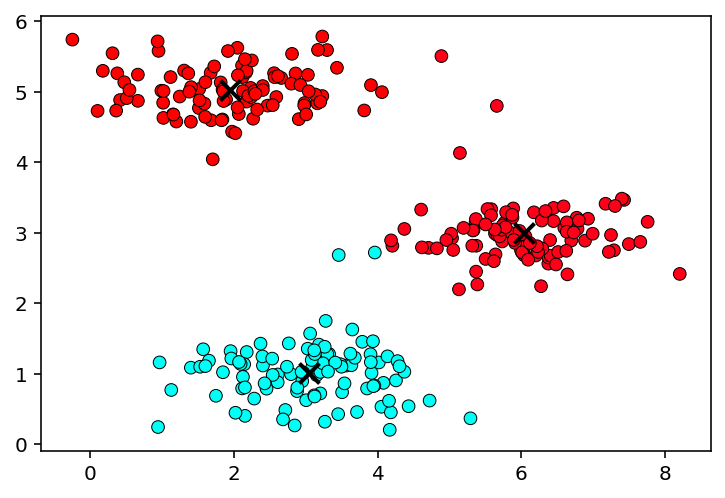

In [9]:
# Plot results at the end of the algorithm:
plot_kmeans_result(X1, res_centroids, res_idx)

## Image Compression with $K$-Means Clustering

### Read Data

In [10]:
# We read the test image
img = plt.imread('data/bird_small.png')
img_shape = img.shape
print(img_shape)

(128, 128, 3)


### Visualize Data

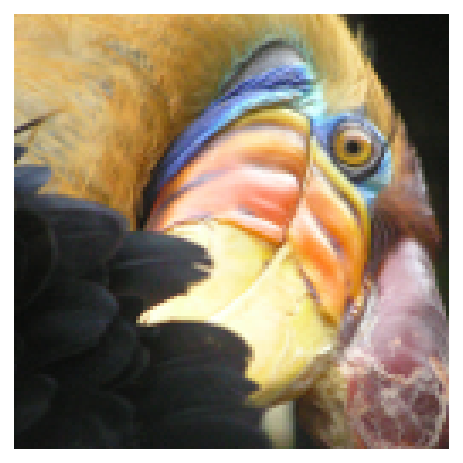

In [11]:
# Show original image
plt.imshow(img)
plt.axis('off')
plt.show()

### Preprocessing

In [12]:
# Normalize pixel color values (these are 8 bit integers (0 - 255))
A = img/255

# Reshape A into matrix by unrolling pixel grid:
X2 = A.reshape(img_shape[0] * img_shape[1], img_shape[2])
print(X2.shape)

(16384, 3)


### Compression

In [13]:
# Define k-means parameters:
# We want to compress the image by only using the K = 16 colors that best group the samples into 3d RGB space
K2 = 16
max_iter2 = 10

In [14]:
# Define function that construct randomized initial centroids from samples:
def kmeans_init_centroids(X, K):
    return X[np.random.choice(X.shape[0], K, replace=False)]

In [15]:
# Construct K random centroids from the samples:
init_centroids2 = kmeans_init_centroids(X2, K2)
print(init_centroids2.shape)

(16, 3)


In [16]:
# Run K-Means algorithm on the image data:
res_centroids2, res_idx2 = run_kmeans(X2, init_centroids2, max_iter2)

In [17]:
# Map each pixel to its assigned centroid, undo normalization and 
# reshape the calculated centroids into the final compressed image data-tensor:
img_compressed = res_centroids2[res_idx2.astype(int), :].reshape(img_shape) * 255
print(img_compressed.shape)

(128, 128, 3)


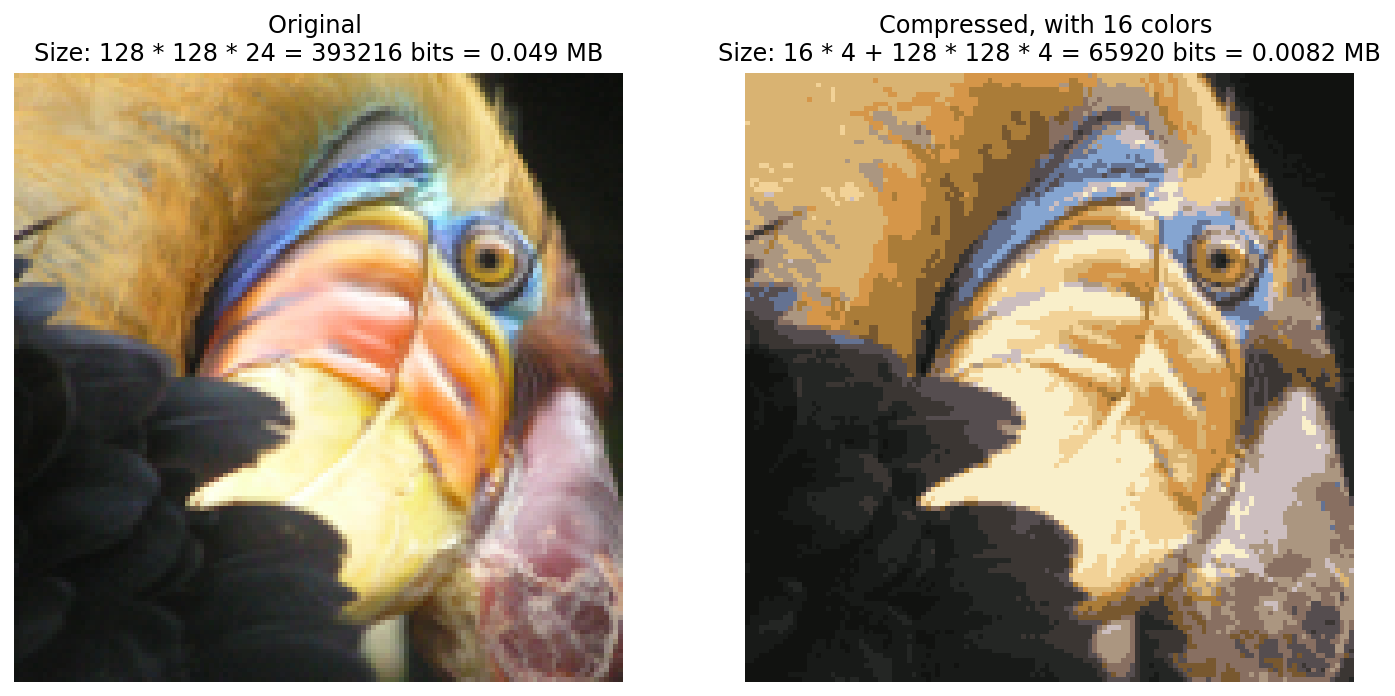

In [18]:
# Show original and compressed image side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,9))
ax1.imshow(img)
ax1.set_title('Original \nSize: 128 * 128 * 24 = 393216 bits = 0.049 MB')
ax2.imshow(img_compressed)
ax2.set_title('Compressed, with 16 colors \nSize: 16 * 4 + 128 * 128 * 4 = 65920 bits = 0.0082 MB')

for ax in fig.axes:
    ax.axis('off')

## Principle Component Analysis

### Read Data

In [19]:
data3 = loadmat('data/ex7data1.mat')
X3 = data3['X']
print(X3.shape)

(50, 2)


### Plot Data

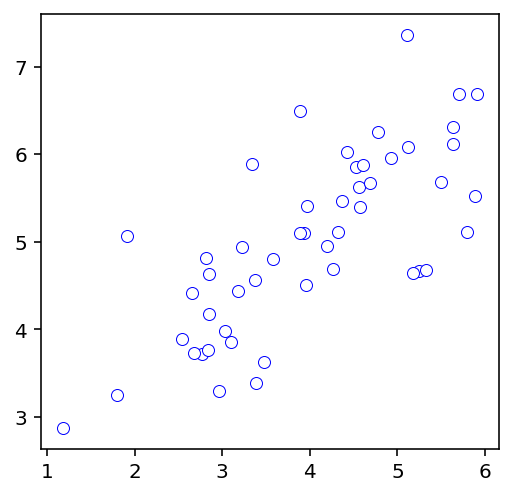

In [20]:
plt.scatter(X3[:,0], X3[:,1], c='w', edgecolors='b', linewidths=0.5)
plt.gca().set_aspect('equal')
plt.show()

### Preprocessing

In [21]:
# Function to normalize data
def feature_normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mu)/std, mu, std

In [22]:
# Feature scale data:
X3_norm, mu, std = feature_normalize(X3)

### Run PCA

In [23]:
# Function to compute covariance matrix:
def compute_covariance_matrix(X):
    return (1/X.shape[0]) * X.T @ X

In [24]:
from scipy import linalg
# Function that performs PCA by calculating the singular value decomposition of the covariance matrix:
def pca(X):
    covariance_matrix = compute_covariance_matrix(X)
    return linalg.svd(covariance_matrix) # Returns U, S, V

In [25]:
# Perform pca on the normalized dataset:
U, S, V = pca(X3_norm)

### Results

In [26]:
# Output the eigenvectors and eigenvalues. We you should expect to see [-0.707107 -0.707107]
print(U)
print(S)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[1.73553038 0.26446962]


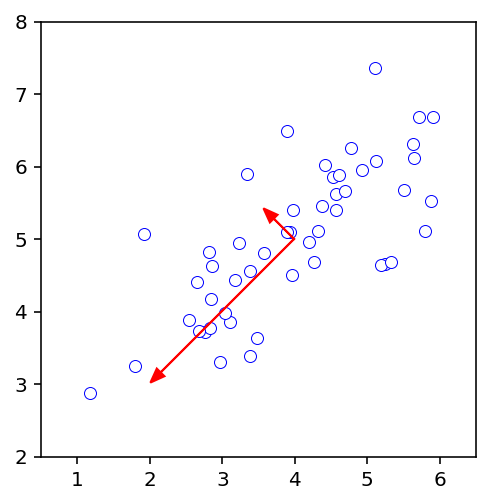

In [27]:
# Plot results:
fig, ax = plt.subplots()
ax.scatter(X3[:,0], X3[:,1], c='w', edgecolors='b', linewidths=0.5)

ax.arrow(mu[0], mu[1], 1.5 * S[0] * U[0, 0], 1.5 * S[0] * U[1, 0], head_width=0.15, head_length=0.2, fc='r', ec='r')
ax.arrow(mu[0], mu[1], 1.5 * S[1] * U[0, 1], 1.5 * S[1] * U[1, 1], head_width=0.15, head_length=0.2, fc='r', ec='r')

ax.axis([0.5, 6.5, 2, 8])
ax.set_aspect('equal')
ax.grid(False)

In [28]:
# Projects the data onto the calculated principle component vectors in U 
def project_data(X, U, K):
    return X @ U[:, :K]

In [29]:
# Project the data onto K = 1 dimension
K = 1
Z = project_data(X3_norm, U, K)
# Projection of the first example (should be around 1.481274): 
print(Z[0])

[1.49631261]


In [30]:
def recover_data(Z, U, K):
    '''Recovers an approximation of the original data when using the 
       projected data'''
    return Z @ U[:,:K].T

In [31]:
# Recover approximation of data by back projecting onto the original space:
X3_rec = recover_data(Z, U, K)
X3_rec[0,:]

array([-1.05805279, -1.05805279])

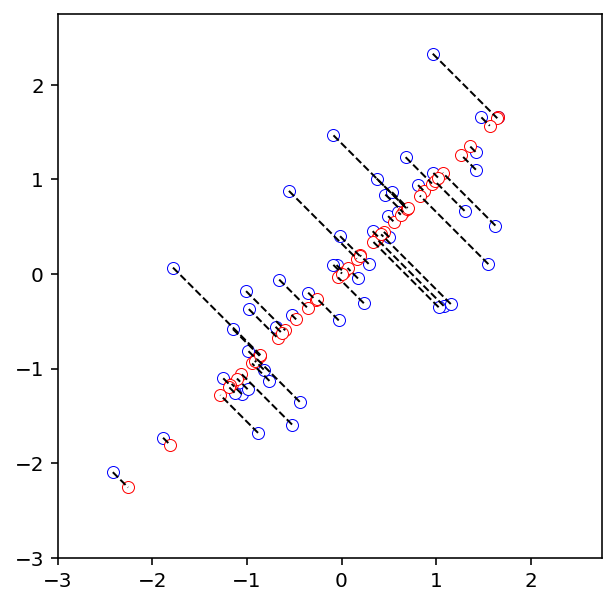

In [32]:
# Visualize the projections (original data = blue, projected data = red):
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X3_norm[:,0], X3_norm[:,1], c='w', edgecolors='b', linewidths=0.5)
ax.set_aspect('equal')
ax.grid(False)
plt.axis([-3, 2.75, -3, 2.75])

ax.scatter(X3_rec[:,0], X3_rec[:,1], c='w', edgecolors='r', linewidths=0.5)

for xnorm, xrec in zip(X3_norm, X3_rec):
    ax.plot([xnorm[0], xrec[0]], [xnorm[1], xrec[1]], '--k', lw=1)

## PCA used on Face Image Dataset

### Read Data

In [33]:
## Face image dataset:
# Load data
data4 = loadmat('data/ex7faces.mat')
X4 = data4['X']
# Rows are unrolled 32x32 size greyscale images
print(X4.shape)

(5000, 1024)


### Plot Data

In [34]:
# Function to plot an nr_examples x nr_examples grid of random images of the data set
def display_data(X, nr_examples, rd=True):
    m, n = X.shape
    example_width = int(np.round(np.sqrt(n)))
    example_height = n // example_width
    
    display_rows = int(np.floor(np.sqrt(nr_examples)))
    display_cols = int(np.ceil(nr_examples / display_rows))
    
    _, axarr = plt.subplots(display_rows, display_cols, figsize=(display_rows, display_cols))
    
    for i in range(display_rows):
        for j in range(display_cols):
            if rd == True:
                axarr[i,j].imshow(X[np.random.randint(m)].reshape(example_width, example_height, order = 'F'), 
                                  cmap='gray')
            else:
                axarr[i,j].imshow(X[j + display_cols * i].reshape(example_width, example_height, order = 'F'), 
                                  cmap='gray')
            axarr[i,j].axis('off')

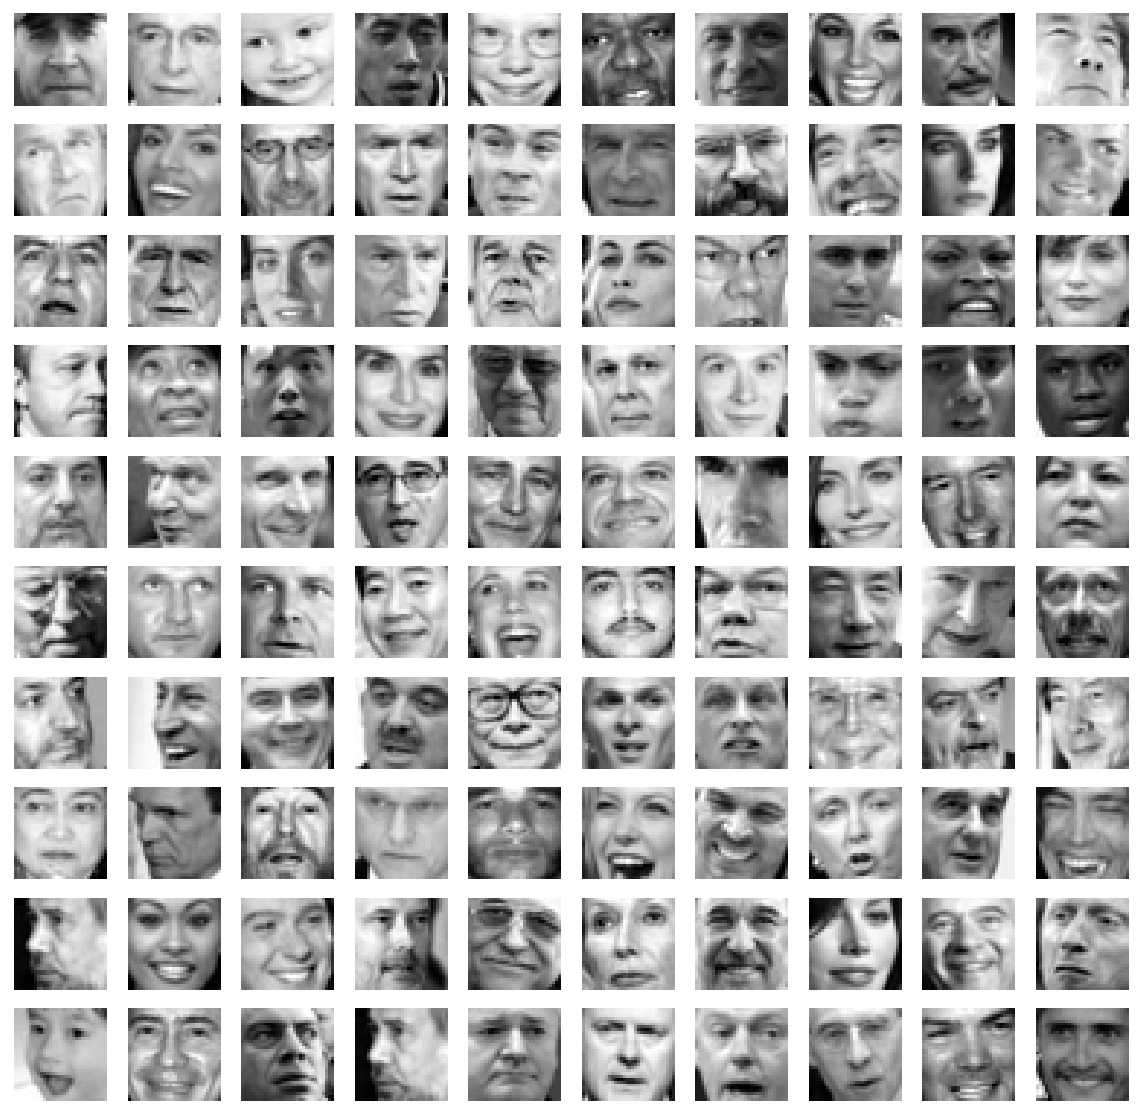

In [35]:
# Show some sample images
display_data(X4, 100)

### Preprocessing

In [36]:
# Normalize data:
X4_norm, mu4, sigma4 = feature_normalize(X4)

### Run PCA

In [37]:
# Perform PCA on the normalized dataset:
U4, S4, V4 = pca(X4_norm)

# Print shapes:
print("U4 shape: ", U4.shape, "\nS4 shape: ", S4.shape, "\nV4 shape: ", V4.shape)

U4 shape:  (1024, 1024) 
S4 shape:  (1024,) 
V4 shape:  (1024, 1024)


### Results

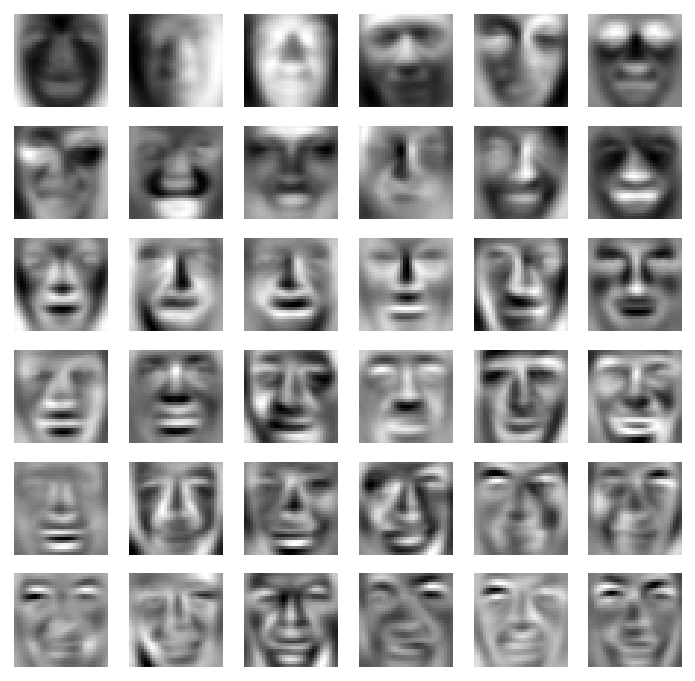

In [38]:
# We can visualize the principle components by reshaping the rows of U4 into 32x32 images:
# Show the first 36 principle components
display_data(U4.T, 36, rd=False)

In [39]:
# Project the data onto K = 100 dimensions
K4 = 100
Z4 = project_data(X4_norm, U4, K4)

In [40]:
# Recover an approximation of the original data from the projections:
X4_rec = recover_data(Z4, U4, K4)

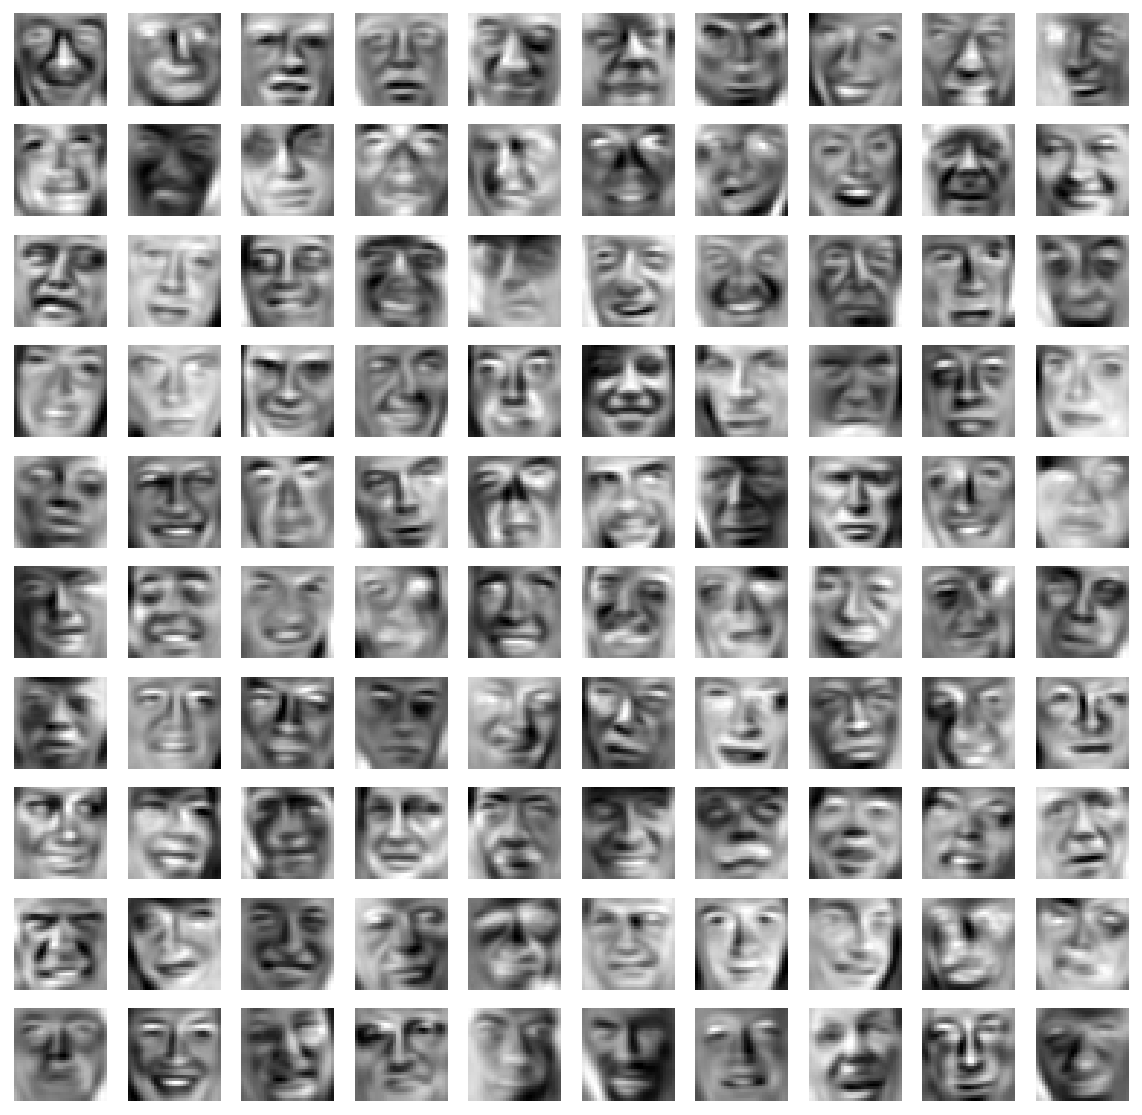

In [41]:
# Show the recovered data of the first 100 faces
display_data(X4_rec, 100, rd=False)

*Notice:* We reduced the size of the samples from 1024 (32x32) to 100 
 (ie less then 1/10th of the originals), the projected data keeps the general appearence and structure of the faces, but
 the fine details are lost. The dimensionally reduced data images could be used to greatly speed up a neural network 
 for face recognition.

## PCA for Data Visualization

In [42]:
# Function that plots data points in 3d space and colors them according to their assignment to different centroids
from mpl_toolkits.mplot3d import Axes3D

def plot_data_points_3d(X, idx):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], c=idx.ravel(), cmap=plt.cm.hsv, s=.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

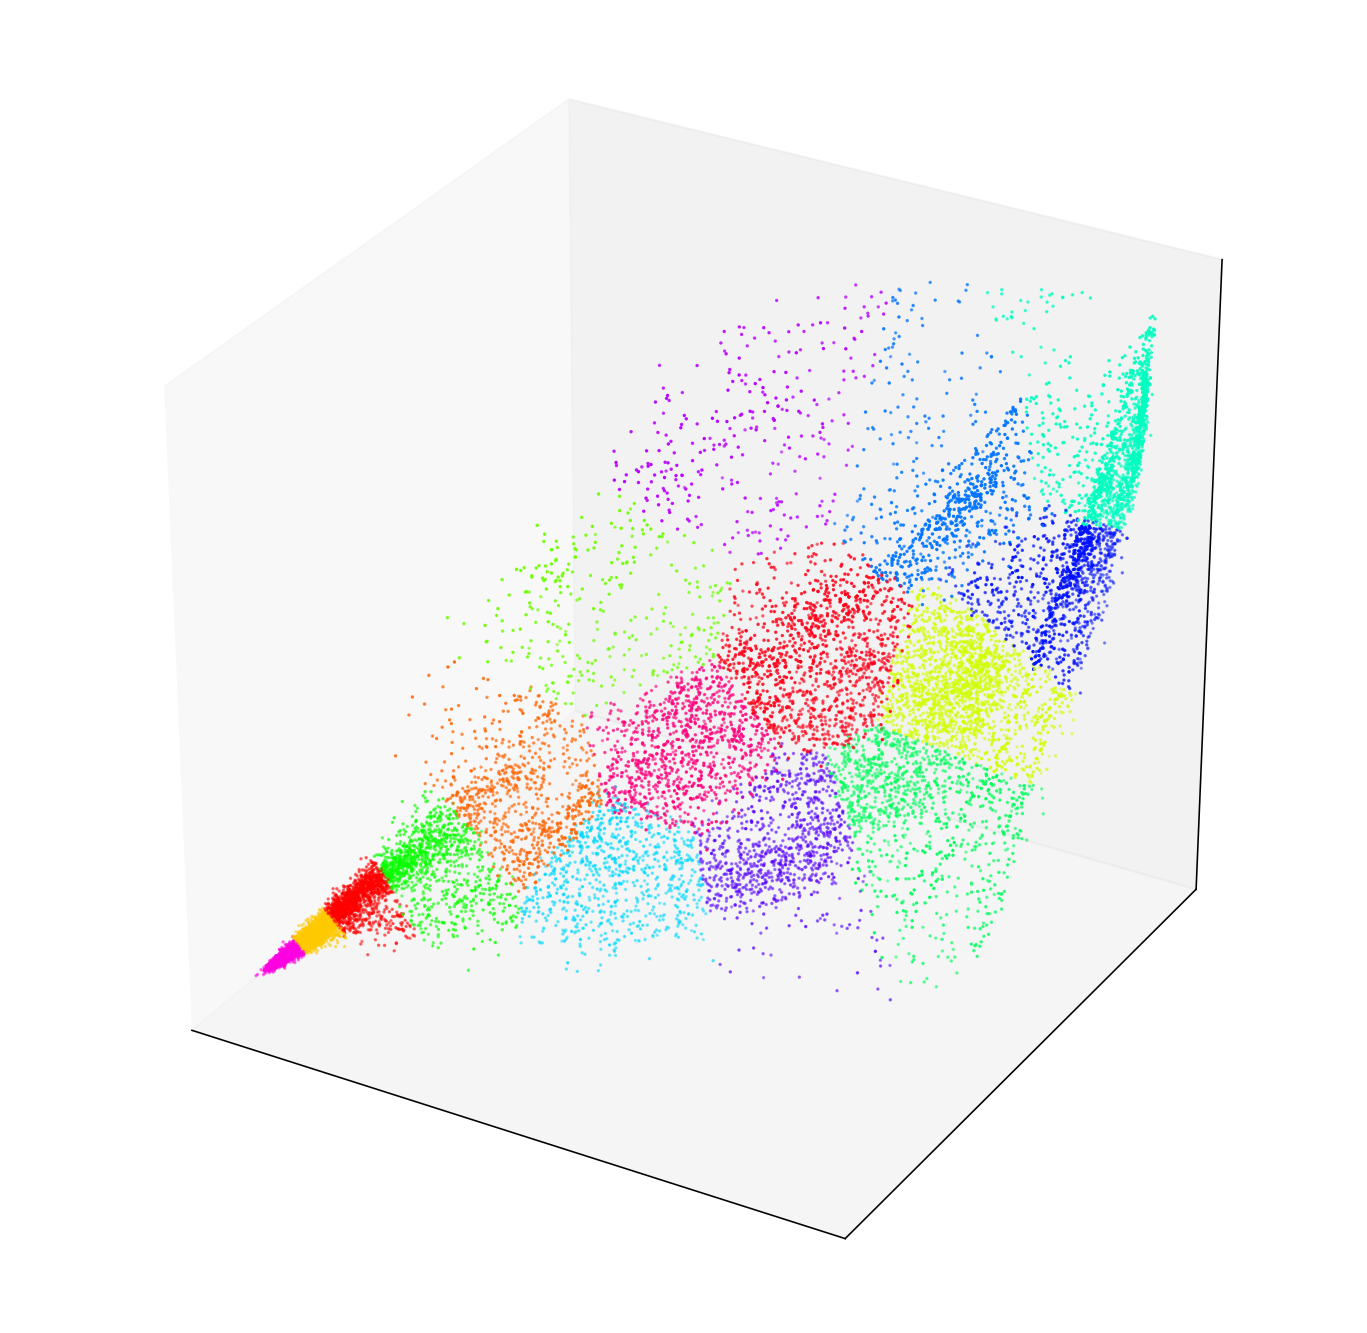

In [43]:
# Visualize clustered data from bird image
plot_data_points_3d(X2, res_idx2)

### Preprocessing

In [44]:
# Normalize data to use pca:
X2_norm, mu2, std2 = feature_normalize(X2)

In [45]:
# Perform pca:
U2, S2, V2 = pca(X2_norm)

In [46]:
# Project the data onto the first 2 principle components (for 2d visualization)
Z2 = project_data(X2_norm, U2, 2)

### Results

In [47]:
# Visualize projected data in 2d:
# Function that plots the data points and colors them according to their assignment to different centroids
def plot_data_points_2(X, idx):
    plt.scatter(X[:,0], X[:,1], c=idx.ravel(), cmap=plt.cm.hsv, s=.1)

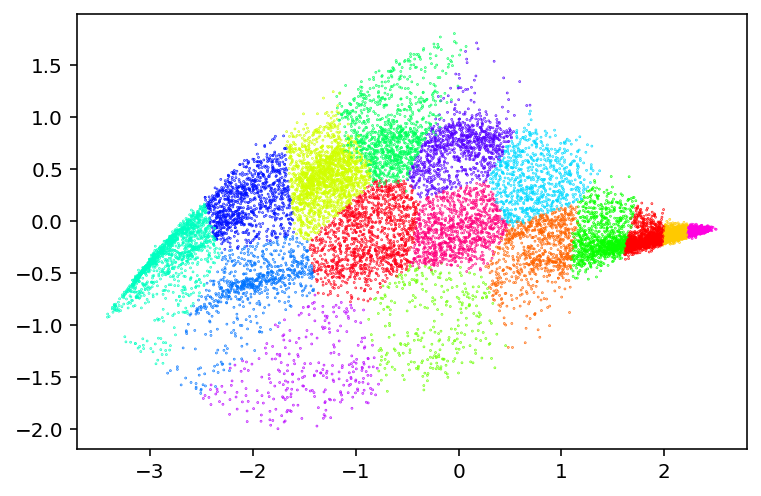

In [48]:
# Visualize projected data in 2d:
plot_data_points_2(Z2, res_idx2)